In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

import autoencoder
import model
import json
import requests
from datetime import datetime
from datetime import timedelta
sns.set()

Instructions for updating:
non-resource variables are not supported in the long term
2.3.1


In [2]:
r = requests.get('https://api.alternative.me/fng/?limit=1500')
data = json.loads(r.text)

df_fearGreed = pd.DataFrame(data["data"], columns=["timestamp", "value"]).rename(columns={"timestamp": "DATE", "value": "Fear&Greed"})
df_fearGreed["DATE"] = pd.to_datetime(df_fearGreed["DATE"], unit="s")
df_fearGreed["Fear&Greed"] = df_fearGreed["Fear&Greed"].astype(float)
df_fearGreed = df_fearGreed.set_index("DATE")

In [3]:
start = datetime(2018, 2, 1)
end = datetime(2021, 5, 14)
Indicators = DataReader(["CBBTCUSD", "CBBCHUSD", "CBCCIND", "CBETHUSD", "sp500", "VIXCLS", "T10YIE", "DGS5", "GOLDPMGBD230NLBM", "SLVPRUSD"], 'fred', start, end)\
    .fillna(method="pad").fillna(method="backfill").join(df_fearGreed).fillna(50)

In [4]:
Indicators.to_csv('dataset/Indicators.csv', index=True, header=True)

In [5]:
Indicators = pd.read_csv('dataset/Indicators.csv', index_col="DATE")

In [6]:
Indicators

,CBBTCUSD,CBBCHUSD,CBCCIND,CBETHUSD,sp500,VIXCLS,T10YIE,DGS5,GOLDPMGBD230NLBM,SLVPRUSD,Fear&Greed
DATE,,,,,,,,,,,
2018-02-01,9014.23,1254.86,4512.850019,1017.48,2821.98,13.47,2.11,2.56,1078.58,17.190,30.0
2018-02-02,8787.52,1181.00,4455.297470,911.99,2762.13,17.31,2.14,2.58,1071.18,17.135,15.0
2018-02-03,9240.00,1269.71,4655.899898,969.40,2762.13,17.31,2.14,2.58,1071.18,17.135,40.0
2018-02-04,8167.91,1156.16,4168.798254,826.00,2762.13,17.31,2.14,2.58,1071.18,17.135,24.0
2018-02-05,6905.19,880.00,3520.919532,693.54,2648.94,37.32,2.10,2.50,1075.01,16.875,11.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-10,55936.77,1320.76,3180.272971,3946.96,4188.43,19.66,2.54,0.80,1513.40,27.735,72.0
2021-05-11,56719.00,1555.59,3180.272971,4172.50,4152.10,21.84,2.53,0.80,1503.15,27.480,61.0
2021-05-12,49095.57,1246.54,3180.272971,3800.24,4063.04,27.59,2.54,0.87,1513.62,27.410,68.0


In [7]:
ROC = True

Indicators_pct = Indicators.pct_change()
date_ori = pd.to_datetime(Indicators_pct.index).tolist()

if ROC:
    Indicators_sca = Indicators.copy()
    Indicators_full = pd.concat([Indicators_sca, Indicators_pct], axis=1)

    minmax = MinMaxScaler().fit(Indicators_full.iloc[:, 0].values.reshape((-1,1)))
    scaler = MinMaxScaler().fit(Indicators_full)
    Indicators_full[:] = scaler.transform(Indicators_full)
else:
    minmax = MinMaxScaler().fit(Indicators.iloc[:, 0].values.reshape((-1,1)))
    scaler = MinMaxScaler().fit(Indicators)
    Indicators_full = Indicators.copy()
    Indicators_full[:] = scaler.transform(Indicators)
    
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

In [8]:
from scipy.stats import spearmanr

c, p = spearmanr(list(Indicators_pct["CBBTCUSD"])[1:], Indicators["Fear&Greed"][:-1])
print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.04971, p-value: 0.08543973899935356


In [9]:
df_log = Indicators_full[1:]
df_log

,CBBTCUSD,CBBCHUSD,CBCCIND,CBETHUSD,sp500,VIXCLS,T10YIE,DGS5,GOLDPMGBD230NLBM,SLVPRUSD,...,CBBCHUSD,CBCCIND,CBETHUSD,sp500,VIXCLS,T10YIE,DGS5,GOLDPMGBD230NLBM,SLVPRUSD,Fear&Greed
DATE,,,,,,,,,,,,,,,,,,,,,
2018-02-02,0.092670,0.660487,0.767465,0.202712,0.262996,0.089922,0.803922,0.824138,0.078403,0.291809,...,0.396774,0.650246,0.465649,0.461613,0.373324,0.347308,0.459720,0.413060,0.612125,0.040210
2018-02-03,0.100152,0.713522,0.813643,0.216750,0.262996,0.089922,0.803922,0.824138,0.078403,0.291809,...,0.530188,0.748540,0.702735,0.560872,0.168189,0.328205,0.448052,0.477503,0.623338,0.381119
2018-02-04,0.082425,0.645636,0.701513,0.181685,0.262996,0.089922,0.803922,0.824138,0.078403,0.291809,...,0.366330,0.493959,0.402690,0.560872,0.168189,0.328205,0.448052,0.477503,0.623338,0.055944
2018-02-05,0.061546,0.480534,0.552373,0.149295,0.206265,0.368458,0.784314,0.796552,0.083653,0.277019,...,0.217524,0.407552,0.384994,0.369083,1.000000,0.303091,0.401742,0.511087,0.570162,0.033654
2018-02-06,0.074498,0.533151,0.624580,0.171373,0.229421,0.266286,0.784314,0.803448,0.089987,0.273038,...,0.554981,0.823500,0.798403,0.642498,0.026666,0.328205,0.460000,0.517870,0.608801,0.075969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-10,0.872281,0.744042,0.473957,0.944849,0.977862,0.122634,1.000000,0.210345,0.684648,0.894767,...,0.376250,0.671942,0.620227,0.512032,0.296238,0.355185,0.506241,0.467769,0.669424,0.116726
2021-05-11,0.885215,0.884436,0.473957,1.000000,0.959653,0.152979,0.995098,0.210345,0.670597,0.880262,...,0.632445,0.671942,0.694472,0.520277,0.247979,0.322915,0.448052,0.413887,0.591117,0.094843
2021-05-12,0.759162,0.699670,0.473957,0.908972,0.915016,0.233018,1.000000,0.234483,0.684950,0.876280,...,0.257546,0.671942,0.486224,0.460486,0.357637,0.333516,0.578734,0.542927,0.614411,0.136937


In [9]:
thought_vector = autoencoder.reducedimension(df_log.values, 4, 0.005, 256, 3000, 300)

epoch: 300 loss: 0.04641416 time: 0.003997802734375
epoch: 600 loss: 0.0330417 time: 0.0039975643157958984
epoch: 900 loss: 0.032669585 time: 0.004996538162231445
epoch: 1200 loss: 0.031876374 time: 0.003997802734375
epoch: 1500 loss: 0.030377764 time: 0.003998279571533203
epoch: 1800 loss: 0.02793085 time: 0.0039975643157958984
epoch: 2100 loss: 0.025113435 time: 0.0039975643157958984
epoch: 2400 loss: 0.023310373 time: 0.0049970149993896484
epoch: 2700 loss: 0.022522554 time: 0.003997802734375
epoch: 3000 loss: 0.023939362 time: 0.003997325897216797


In [11]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.5

In [12]:
tf.reset_default_graph()
modelnn = model.Model(0.01, num_layers, thought_vector.shape[1], size_layer, 1, dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0)
        batch_y = df_log.values[k + 1: k + timestamp + 1, 0].reshape([-1, 1])
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        init_value = last_state
        total_loss += loss
    total_loss /= (thought_vector.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 100 avg loss: 0.009694368880736874
epoch: 200 avg loss: 0.008460726189514389
epoch: 300 avg loss: 0.005652287656848784
epoch: 400 avg loss: 0.007343103236780735
epoch: 500 avg loss: 0.0051520706670999065


In [13]:
boundary = (thought_vector.shape[0] // timestamp) * timestamp
predict_days = len(df_log) - boundary

output_predict = np.zeros(((thought_vector.shape[0] // timestamp) * timestamp, 1))
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[k: k + timestamp, :] = out_logits
    
out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(thought_vector[-predict_days:, :], axis = 0),
                                  modelnn.hidden_layer: init_value})
init_value = last_state
output_predict_last = out_logits

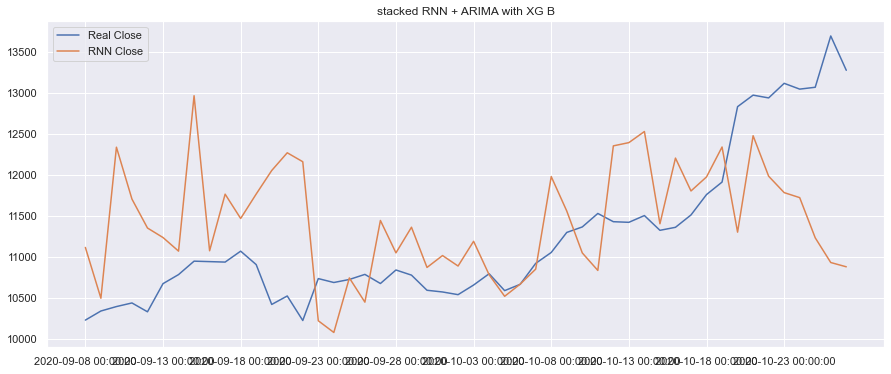

In [24]:
last =50

plt.figure(figsize = (15,6))
x_range = np.arange(boundary)[-last:]
plt.plot(x_range, reverse_close(df_log.iloc[boundary-last:boundary,0].values), label = 'Real Close')
plt.plot(x_range, reverse_close(output_predict)[-last:], label = 'RNN Close')
plt.legend()
plt.xticks(x_range[::5], date_ori[:boundary][-last:][::5])
plt.title('stacked RNN + ARIMA with XG B')
plt.show()

In [42]:
import statsmodels.api as sm

resDiff = sm.tsa.arma_order_select_ic(df_log.iloc[:,0].values, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_r

ARMA(p,q) = (6, 4) is the best.


C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [47]:
arima=sm.tsa.statespace.SARIMAX(df_log.iloc[:,0].values, order=(resDiff['aic_min_order'][0], D, resDiff['aic_min_order'][1]), seasonal_order=(1, 0, 1, 12)).fit(disp=-1)
best_aic = arima.aic
best_aic

C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


-4150.201070274342

In [25]:
import statsmodels.api as sm
from itertools import product
from scipy import stats
    
Qs = range(0, 3)
qs = range(0, 2)
Ps = range(0, 3)
ps = range(0, 2)

# ps = [resDiff['aic_min_order'][0]]
# qs = [resDiff['aic_min_order'][1]]

ps = [6]
qs = [4]

D=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
best_aic = float("inf")
for param in parameters_list:
#     try:
    arima=sm.tsa.statespace.SARIMAX(df_log.iloc[:,0].values, order=(param[0], D, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
#     except:
#         continue
    aic = arima.aic
    if aic < best_aic and aic:
        best_arima = arima
        best_aic = aic
        
best_aic

C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tangji\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Ma

-4047.450850437203

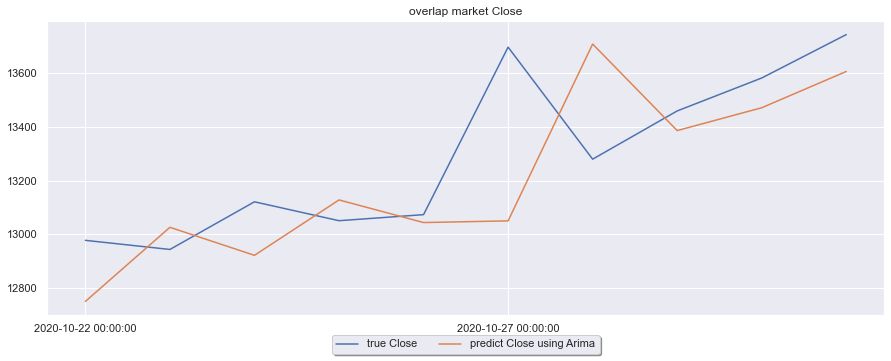

In [26]:
last =10

pred_arima = best_arima.predict()
pred_arima_last = pred_arima[-predict_days:]
x_range = np.arange(df_log.shape[0])[-last:]
fig = plt.figure(figsize = (15,6))
ax = plt.subplot(111)
ax.plot(x_range, reverse_close(df_log.iloc[:,0].values)[-last:], label = 'true Close')
ax.plot(x_range, reverse_close(pred_arima)[-last:], label = 'predict Close using Arima')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.xticks(x_range[::5], date_ori[-last:][::5])
plt.title('overlap market Close')
plt.show()

In [27]:
stack_predict = np.vstack([pred_arima[:boundary], output_predict.reshape((-1))]).T
stack_predict_last = np.vstack([pred_arima_last, output_predict_last.reshape((-1))]).T

In [28]:
where_below_0 = np.where(stack_predict < 0)
where_higher_1 = np.where(stack_predict > 1)
stack_predict[where_below_0[0], where_below_0[1]] = 0
stack_predict[where_higher_1[0], where_higher_1[1]] = 1

where_below_0_last = np.where(stack_predict_last < 0)
where_higher_1_last = np.where(stack_predict_last > 1)
stack_predict_last[where_below_0_last[0], where_below_0_last[1]] = 0
stack_predict_last[where_higher_1_last[0], where_higher_1_last[1]] = 1

In [29]:
corr_df = pd.DataFrame(np.hstack([stack_predict, df_log.values[:boundary, 0].reshape((-1,1))]))

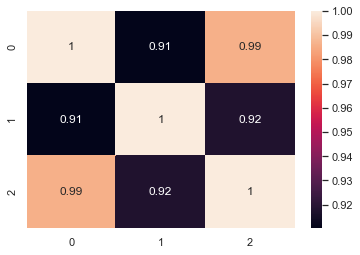

In [30]:
sns.heatmap(corr_df.corr(), annot= True)
plt.show()

In [31]:
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = df_log.values[:boundary, 0]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict,train_Y, eval_set=[(stack_predict,train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(learning_rate=0.05, max_depth=7, n_estimators=10000,
             objective='reg:logistic')

In [32]:
stacked = clf.predict(stack_predict)
stacked_last = clf.predict(stack_predict_last)

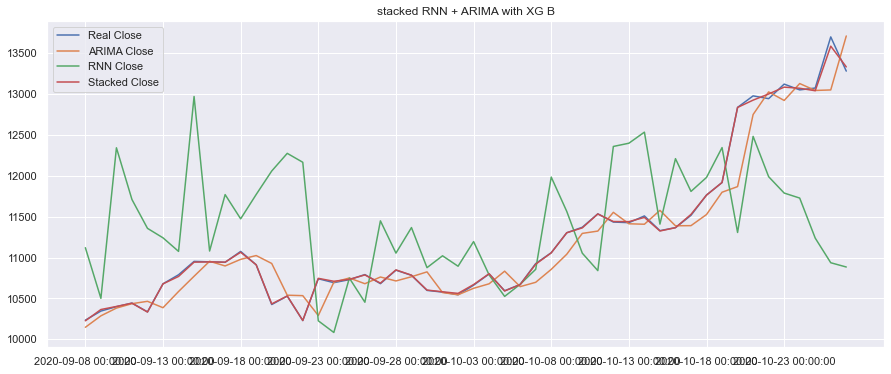

In [35]:
last =50

plt.figure(figsize = (15,6))
x_range = np.arange(boundary)[-last:]
plt.plot(x_range, reverse_close(train_Y)[-last:], label = 'Real Close')
plt.plot(x_range, reverse_close(pred_arima[:boundary])[-last:], label = 'ARIMA Close')
plt.plot(x_range, reverse_close(output_predict)[-last:], label = 'RNN Close')
plt.plot(x_range, reverse_close(stacked)[-last:], label = 'Stacked Close')
plt.legend()
plt.xticks(x_range[::5], date_ori[:boundary][-last:][::5])
plt.title('stacked RNN + ARIMA with XG B')
plt.show()

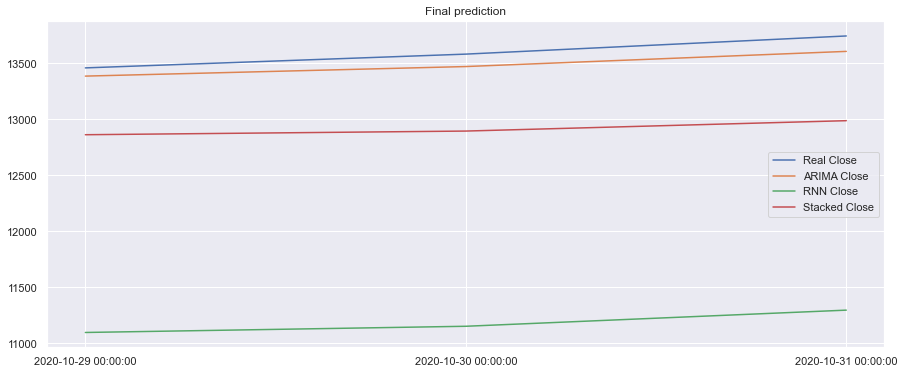

In [34]:
plt.figure(figsize = (15,6))
x_range = np.arange(5)
plt.xticks(x_range[-predict_days:], date_ori[-predict_days:])
plt.plot(x_range[-predict_days:], reverse_close(df_log.iloc[-predict_days:,0].values), label = 'Real Close')
plt.plot(x_range[-predict_days:], reverse_close(pred_arima_last), label = 'ARIMA Close')
plt.plot(x_range[-predict_days:], reverse_close(output_predict_last), label = 'RNN Close')
plt.plot(x_range[-predict_days:], reverse_close(stacked_last), label = 'Stacked Close')
plt.legend()
plt.title('Final prediction')
plt.show()